<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataMinig/blob/main/20231213/%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データマイニング第12回（2023/12/13）

#本日の講義の目的

機械学習の準備として、
ロジスティック回帰を例にして、予測精度を向上させるテクニックに関して
詳しく説明を行う。

1. 説明変数にカテゴリ変数を用いる

1. ハイパーパラメータチューニング


## 準備


In [ ]:
# インストール
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=652eb7ee3d32385ea111146ee36d5bb3b166e4189db60f7c2611f3792f06a4ec
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なライブラリーのインポート

In [ ]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

In [ ]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# その他必要なライブラリー
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### 【参考】ロジスティック回帰ライブラリー
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Titanic データを使った例


In [ ]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset("titanic") #タイタニックのデータ
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


##データの説明

1912年に発生したタイタニック号の沈没事故の乗客情報のデータを学習し、
乗客の生存を予測するAIモデルを作成する。



列名 | 型 | 意味
---  | --- | --
survived	| カテゴリ | 生存フラグ（0=死亡、1=生存）
pclass	|  カテゴリ |チケットクラス（1stクラス、2ndクラス、3rdクラス）＊classと同じ内容のため用いない
sex	|  カテゴリ |性別（male：男性、female：女性）
sge	|  数値 |年齢
sibsp	|  数値 |タイタニックに同乗している兄弟/配偶者の数
parch	|  数値 |タイタニックに同乗している親/子供の数
fare	|  数値 |料金
embarked	|  カテゴリ |出港地（タイタニックへ乗った港）(C=Cherbourg、Q=Queenstown、S=Southampton)
class |  カテゴリ |乗船クラス
who | カテゴリ |男性 or 女性
adult_male |  カテゴリ |成人男性であるかどうか
deck |  カテゴリ |乗船していたデッキ
embark_town |  カテゴリ |出港地 ＊embarked と同じ内容のため用いない
alive |  カテゴリ |生存したかどうか ＊survived と同じ内容ため用いない
alone |  カテゴリ |一人であったかどうか

## 前処理

このデータには欠損値が含まれているため、前処理を行う。

In [ ]:
# 欠損値を確認する
data.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [ ]:
# age, embarked, の欠損値を埋める。
# deck は欠損値が多数あるため説明変数には用いないことにする。

# 平均値で欠損値を埋める。
data['age'].fillna(data['age'].mean(), inplace=True)

# 最頻値で欠損値を埋める。
data['embarked'].fillna(data['embarked'].mode()[0], inplace=True)
data['embark_town'].fillna(data['embark_town'].mode()[0], inplace=True)

# 結果を確認
data.isnull().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64

## 基礎集計

         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.002015    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   29.699118    0.000000    0.000000   14.454200
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

生存者数と死亡者数の集計:
0    549
1    342
Name: survived, dtype: int64

クラスごとの生存率:
class
First     0.629630
Second    0.472826
Third     0.242363
Name: survived, dtype: float64

性別ごとの生存率:
sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

年齢の分布:
Axes(0.125,0.11;0.775x0.77)


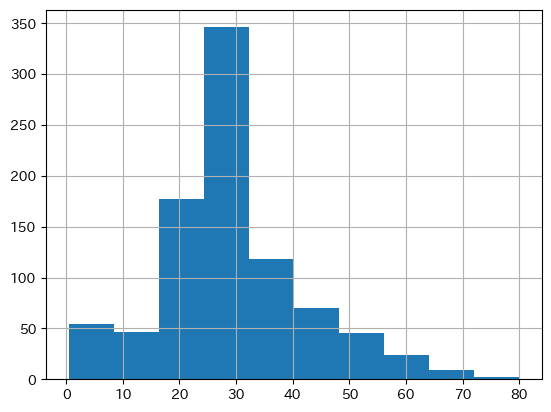

In [13]:
# 基本的な統計情報を表示
print(data.describe())

# 生存者数と死亡者数を集計
survived_counts = data['survived'].value_counts()
print("\n生存者数と死亡者数の集計:")
print(survived_counts)

# 乗客のクラスごとの生存率を計算
survival_rate_by_class = data.groupby('class')['survived'].mean()
print("\nクラスごとの生存率:")
print(survival_rate_by_class)

# 性別ごとの生存率を計算
survival_rate_by_gender = data.groupby('sex')['survived'].mean()
print("\n性別ごとの生存率:")
print(survival_rate_by_gender)

# 年齢の分布を表示
print("\n年齢の分布:")
print(data['age'].hist())

## ロジスティック回帰モデルの構築

まず、数値型の項目のみでモデルを作成し精度を確認する。

In [8]:
# 説明変数と目的変数を選択
# 数値データのみで予測
X = data[[ 'age', 'fare', 'sibsp', 'parch']]
y = data[['survived']]

Accuracy: 0.6815642458100558


<Axes: >

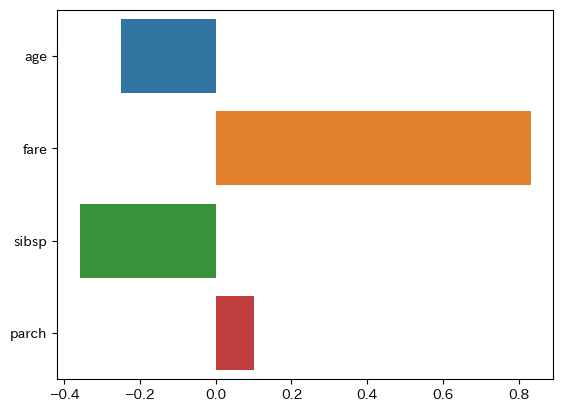

In [10]:
# データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 説明変数の標準化の準備
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルの準備
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train.values.ravel()  )

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
# plt.show()

### 回帰係数

回帰係数の正負は、以下の意味合いがある。

* 回帰係数が正：大きいほど1になりやすい。（小さいほど0になりやすい）
* 回帰係数が負：大きいほど0になりやすい。（小さいほど1になりやすい）

In [11]:
# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

Accuracy: 0.8100558659217877


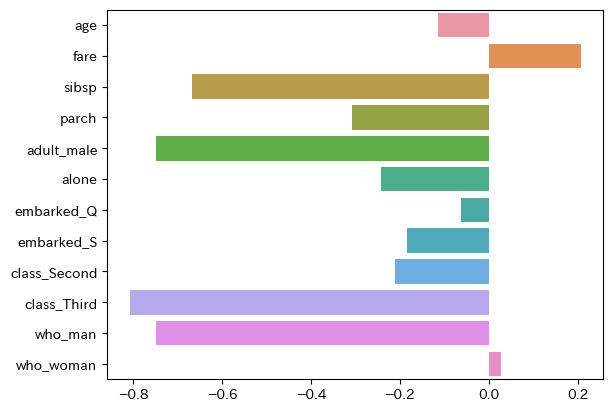

In [12]:
# データを訓練セットとテストセットに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 特徴量の重要度を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

## ハイパーパラメータチューニング

## 正則化パラメータ

ロジスティック回帰には、「正則化パラメータ」があり、
例えば、以下のように指定する。

```
model = LogisticRegression(C=1.0)
```

1.0の部分を変更することで精度をより向上させることが可能である。
なお、今までは指定を省略していたが、デフォルトとして C=1.0 が指定されていた。


正則化パラメータとして、どの値が適切かを調べるためには、
**グリッドサーチ**が用いられる。

そのためには、正則化パラメータの候補を以下のように設定する。

```
param_grid = {'C': [ 0.1, 0.15, 0.2, 0.3, 1, 2]}
```

正則化パラメータの候補は正の値で、
多くの場合は 0.1 ～ 100の範囲とすると良いことが知られている。


候補を設定したら、GridSearchCV を以下のように設定し、fitで実行する。

```
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train.values.ravel() )
```

実行した結果、最適なモデルを以下のように得ることができる。
```
best_model = grid_search.best_estimator_
```

In [18]:
# 必要なライブラリをインポート
from sklearn.model_selection import GridSearchCV

# パラメータグリッドを設定
param_grid = {'C': [ 0.1, 0.15, 0.2, 0.3, 1, 2]}

# GridSearchCVを設定
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# グリッドサーチを実行
grid_search.fit(X_train_scaled, y_train.values.ravel() )

# 最適なパラメータでテストデータを評価
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train.values.ravel() )

y_pred = best_model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print(f"Validation set accuracy: {accuracy}")


Validation set accuracy: 0.8300561797752809


grid_search.best_params_ には、最適なパラメータが格納されている。

In [20]:
# 最適なパラメータとスコアを出力
print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.15}


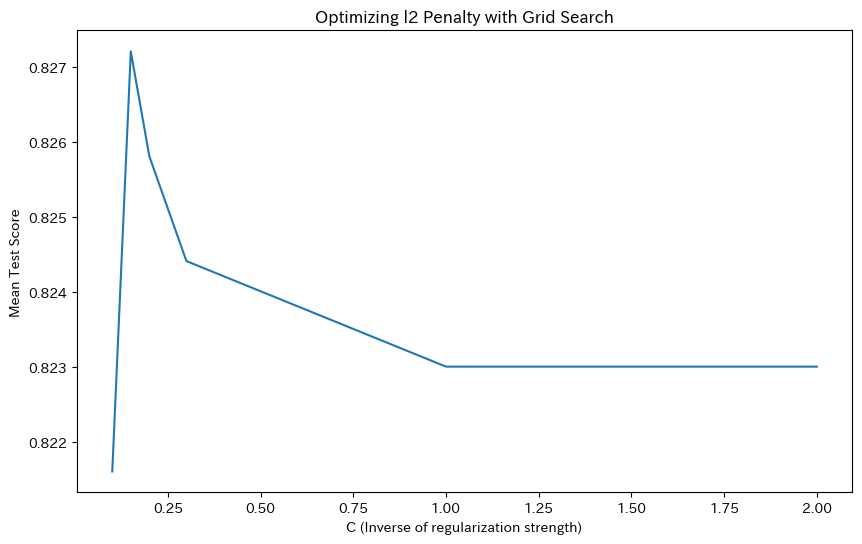

In [21]:

# 精度が向上する様子をグラフで示す
scores = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
sns.lineplot(x=param_grid['C'], y=scores)
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Mean Test Score')
plt.title('Optimizing l2 Penalty with Grid Search')
plt.show()

---
---
---


# その他の参考となるサイト
https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package



https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
